# Channel timing
This notebooks studies the timing characteristics of a CDL channel model. The same principals also apply to TDL channel models.

In [1]:
import numpy as np
import scipy.io
import time

from neoradium import CdlChannel, AntennaPanel, random

Execution Time (Linear): 0.1457
Execution Time (Polar): 0.2356
Execution Time (Nearest): 0.0185
Execution Time (Matlab): 0.0185


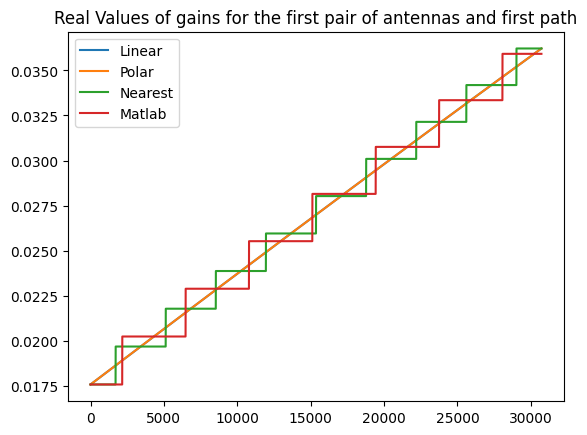

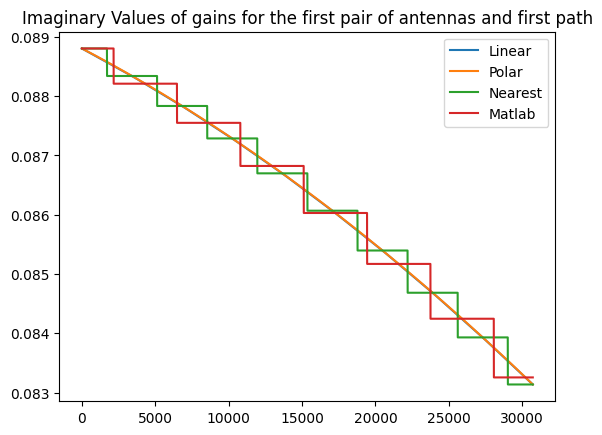

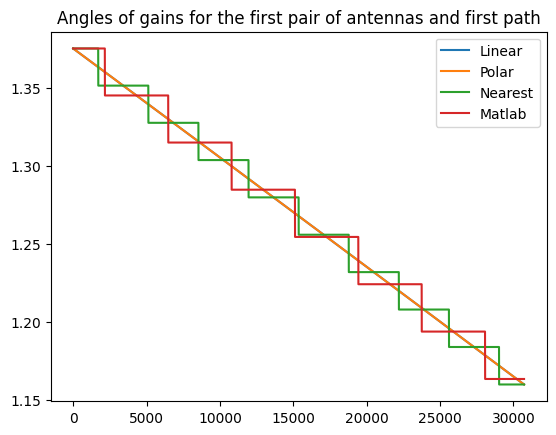

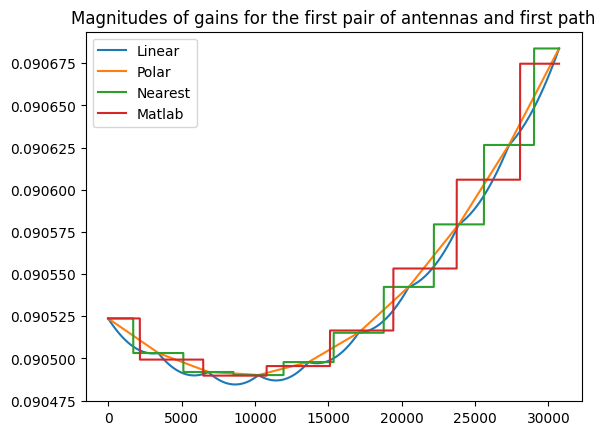

In [2]:
speedKmh = 15  # speed of UE device: 15 km/h
speed = speedKmh*1000/3600
c = 299792458  # Speed of light
f = 4e9        # 4 GHz
d = speed*f/c  # Doppler Shift

gains = []

# Trying different timing methods
for timingMethod in ['Linear', 'Polar', 'Nearest', 'Matlab']:
    channel = CdlChannel('C', delaySpread=10, carrierFreq=f, dopplerShift=d,
                         txAntenna = AntennaPanel([2,2], polarization="x", matlabOrder=True),
                         rxAntenna = AntennaPanel([1,1], polarization="+", matlabOrder=True),
                         txAntennaOrientation = [10, 20, 30],
                         angleMeans = [130,70,80,110], angleSpreads = [5,11,3,3],  # Angle Scaling
                         seed = 123,                                               # Repeatable results
                         timing = timingMethod)
    
    numSamples = int(channel.sampleRate * 0.001)  # Number of samples for one subframe.

    t0= time.time()
    channelTimes = channel.getChannelTimes(numSamples)
    channelGains = channel.getChannelGains(channelTimes)                   # Shape: nc x nr x nt x np
    gains += [ channel.upSample(channelGains, channelTimes, numSamples) ]  # Shape: ns x nr x nt x np
    print("Execution Time (%s): %.4f"%(timingMethod, time.time()-t0))

import matplotlib.pyplot as plt
pp = 1
for i,timingMethod in enumerate(['Linear', 'Polar', 'Nearest', 'Matlab']):
    plt.plot(np.real(gains[i])[:,0,0,pp], label=timingMethod)
plt.legend()
plt.title("Real Values of gains for the first pair of antennas and first path");
plt.show()

for i,timingMethod in enumerate(['Linear', 'Polar', 'Nearest', 'Matlab']):
    plt.plot(np.imag(gains[i])[:,0,0,pp], label=timingMethod)
plt.legend()
plt.title("Imaginary Values of gains for the first pair of antennas and first path");
plt.show()

for i,timingMethod in enumerate(['Linear', 'Polar', 'Nearest', 'Matlab']):
    plt.plot(np.angle(gains[i])[:,0,0,pp], label=timingMethod)
plt.legend()
plt.title("Angles of gains for the first pair of antennas and first path");
plt.show()

for i,timingMethod in enumerate(['Linear', 'Polar', 'Nearest', 'Matlab']):
    plt.plot(np.abs(gains[i])[:,0,0,pp], label=timingMethod)
plt.legend()
plt.title("Magnitudes of gains for the first pair of antennas and first path");
plt.show()


Testing with 'Linear':
  Max Absolute Difference: 5.369472471200176e-05


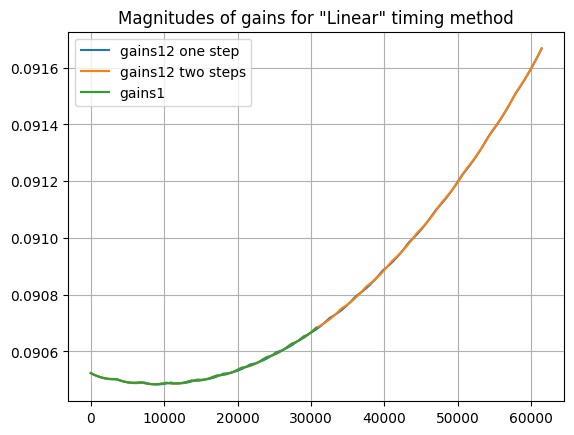

Testing with 'Polar':
  Max Absolute Difference: 7.4682821260964236e-06


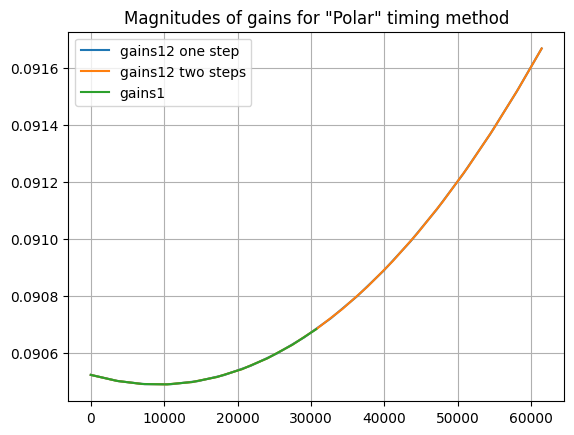

Testing with 'Nearest':
  Max Absolute Difference: 0.010692990186467183


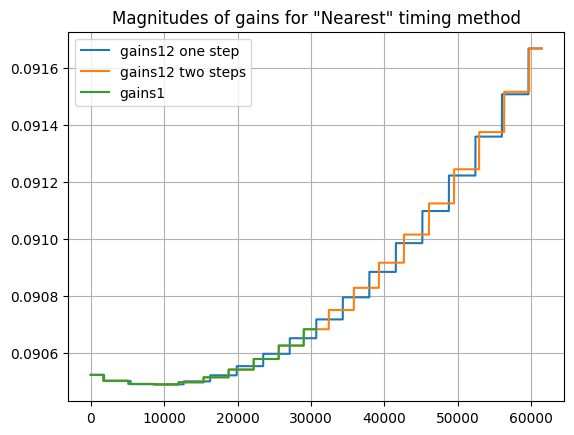

Testing with 'Matlab':
  Max Absolute Difference: 0.01192575626972184


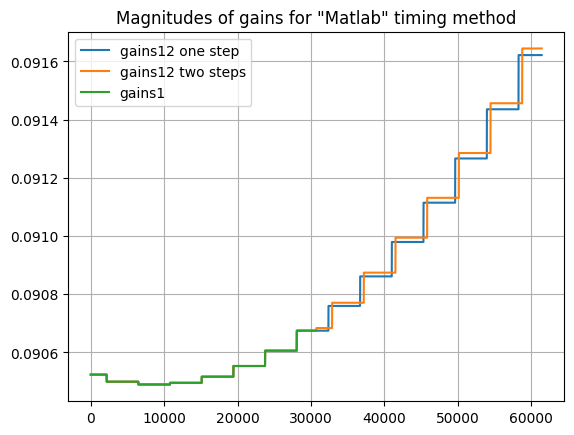

In [3]:
# Checking the continuity of the channel gains for each timing method.
# Running in 2 steps once and then running in one step with twice the samples and comparing the results.
for timingMethod in ['Linear', 'Polar', 'Nearest', 'Matlab']:
    print("Testing with '%s':"%(timingMethod))
    channel = CdlChannel('C', delaySpread=10, carrierFreq=f, dopplerShift=d,
                         txAntenna = AntennaPanel([2,2], polarization="x", matlabOrder=True),
                         rxAntenna = AntennaPanel([1,1], polarization="+", matlabOrder=True),
                         txAntennaOrientation = [10, 20, 30],
                         angleMeans = [130,70,80,110], angleSpreads = [5,11,3,3],  # Angle Scaling
                         seed = 123,                                               # Repeatable results
                         timing = timingMethod)

    numSamples = int(channel.sampleRate * 0.001)  # Number of samples for one subframe.

    # get the gains for "numSamples" samples
    channelTimes = channel.getChannelTimes(numSamples)
    channelGains = channel.getChannelGains(channelTimes)                    # Shape: nc x nr x nt x np
    gains1 = channel.upSample(channelGains, channelTimes, numSamples)       # Shape: ns x nr x nt x np

    # Advance the channel state.
    channel.goNext()

    # get the gains again for the same number of samples.
    channelTimes = channel.getChannelTimes(numSamples)
    channelGains = channel.getChannelGains(channelTimes)                    # Shape: nc x nr x nt x np
    gains2 = channel.upSample(channelGains, channelTimes, numSamples)       # Shape: ns x nr x nt x np

    # Concatenate the results
    gains12c = np.concatenate([gains1, gains2])                             # Shape: 2*ns x nr x nt x np

    # Restart the channel mode. Note that we want to restart the random generator so that
    # we start with the same random initial values.
    channel.restart(restartRanGen=True)
    
    # Get the 1-step gains for twice the number of samples for each step.
    channelTimes = channel.getChannelTimes(2*numSamples)
    channelGains = channel.getChannelGains(channelTimes)                    # Shape: 2*nc x nr x nt x np
    gains12 = channel.upSample(channelGains, channelTimes, 2*numSamples)    # Shape: 2*ns x nr x nt x np

    # Compare the results
    print("  Max Absolute Difference:", np.abs(gains12-gains12c).max())
    
    # Draw the continuity magnitude graphs for each interpolation method.
    pp=1
    plt.plot(np.abs(gains12)[:,0,0,pp],label="gains12 one step")
    plt.plot(np.abs(gains12c)[:,0,0,pp],label="gains12 two steps")
    plt.plot(np.abs(gains1)[:,0,0,pp],label="gains1")
    plt.legend()
    plt.grid()
    plt.title("Magnitudes of gains for \"%s\" timing method"%(timingMethod));
    plt.show()

In [4]:
# Checking the continuity of the channel fileters.
# Running in 2 steps first and then running in one step with the same data repeated 2-times and comparing the 
# results.

channel = CdlChannel('C', delaySpread=10, carrierFreq=f, dopplerShift=d,
                     txAntenna = AntennaPanel([2,2], polarization="x", matlabOrder=True),
                     rxAntenna = AntennaPanel([1,1], polarization="+", matlabOrder=True),
                     txAntennaOrientation = [10, 20, 30],
                     angleMeans = [130,70,80,110], angleSpreads = [5,11,3,3],  # Angle Scaling
                     seed = 123,                                               # Repeatable results
                     timing = "Polar")

# Create some random signal (1 ms)
random.setSeed(123)
txWaveform = random.normal(0,1,   # Standard Normal Distribution
                        (channel.nrNt[1],int(channel.sampleRate*0.001))) # Shape: Nt x NumSamples

# get filter outputs for the input data.
channelTimes = channel.getChannelTimes(numSamples)
filterOutput1 = channel.channelFilter.applyToSignal(txWaveform)               # Shape: ns x nt x np

# Advance the filter state.
channel.goNext()

# get filter output again for the same input data.
filterOutput2 = channel.channelFilter.applyToSignal(txWaveform)               # Shape: ns x nt x np

# Concatenate the results
filterOutput12c = np.concatenate([filterOutput1, filterOutput2])              # Shape: 2*ns x nt x np

# Restart the channel mode. Note that we want to restart the random generator so that
# we start with the same random initial values.
channel.restart(restartRanGen=True)

txWaveform12 = np.concatenate(2*[txWaveform], axis=1)  # Repeat the txWaveform
filterOutput12 = channel.channelFilter.applyToSignal(txWaveform12)            # Shape: 2*ns x nt x np

# Compare the results:
print("Max Absolut Difference:", np.abs(filterOutput12-filterOutput12c).max())

Max Absolut Difference: 8.881784197001252e-16
